# 💉 Clasificación de Vacunacion Covid con RNN vs LSTM

## 🔹 Paso 1: Cargar los datos desde UCI

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv"
df = pd.read_csv(url)

pfizer = df[df['vaccine'] == 'Pfizer/BioNTech'].copy()  
astrazeneca = df[df['vaccine'] == 'Oxford/AstraZeneca'].copy()

pfizer['tipo_vacuna'] = 'Pfizer'
astrazeneca['tipo_vacuna'] = 'AstraZeneca'

df_combinado = pd.concat([pfizer, astrazeneca], ignore_index=True)
df_combinado.shape

(26502, 5)

## 🔹 Paso 2: Generar descripciones sintéticas como texto

In [3]:
def generar_descripcion_vacuna(row):
    return (
        f"País: {row['location']}, Fecha: {row['date']}, "
        f"Vacuna: {row['vaccine']}, "  
        f"Dosis totales: {row['total_vaccinations']}, "
        f"Personas vacunadas: {row.get('people_vaccinated', 'N/A')}, "  
        f"Esquema completo: {row.get('people_fully_vaccinated', 'N/A')}."
    )

df_combinado['descripcion'] = df_combinado.apply(generar_descripcion_vacuna, axis=1)
resultado = df_combinado[['descripcion', 'tipo_vacuna']]

resultado.sample(5)

,descripcion,tipo_vacuna
20325,"País: France, Fecha: 2021-05-03, Vacuna: Oxfor...",AstraZeneca
13114,"País: South Korea, Fecha: 2021-10-06, Vacuna: ...",Pfizer
23937,"País: Slovakia, Fecha: 2022-03-11, Vacuna: Oxf...",AstraZeneca
3880,"País: Ecuador, Fecha: 2021-11-09, Vacuna: Pfiz...",Pfizer
15980,"País: Uruguay, Fecha: 2021-11-23, Vacuna: Pfiz...",Pfizer


## 🔹 Paso 3: Preprocesar texto y etiquetas

In [4]:
# Limpieza de texto
df_combinado['descripcion'] = df_combinado['descripcion'].str.replace(
    r'Pfizer|AstraZeneca|BioNTech|Oxford', 
    '[VACUNA]', 
    regex=True
)

# Codificar clases 
le = LabelEncoder()
df_combinado['tipo_cod'] = le.fit_transform(df_combinado['tipo_vacuna'])  
num_classes = len(le.classes_)  

# Tokenización
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_combinado['descripcion'])
sequences = tokenizer.texts_to_sequences(df_combinado['descripcion'])
max_len = max(len(s) for s in sequences)
X = pad_sequences(sequences, maxlen=max_len)

# Preparar etiquetas
y = to_categorical(df_combinado['tipo_cod'], num_classes=num_classes)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
vocab_size = len(tokenizer.word_index) + 1

print(f"Max len: {max_len}, Vocab size: {vocab_size}, Classes: {num_classes}")

Max len: 21, Vocab size: 25737, Classes: 2


In [5]:
# Verifica el balance de clases
print(pd.Series(df_combinado['tipo_vacuna']).value_counts())

# Revisa si hay descripciones duplicadas
print(f"Descripciones duplicadas: {df_combinado['descripcion'].duplicated().sum()}")

tipo_vacuna
Pfizer         17843
AstraZeneca     8659
Name: count, dtype: int64
Descripciones duplicadas: 2


## 🔹 Paso 4: Simple RNN

In [6]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len))
model_rnn.add(SimpleRNN(units=32))
model_rnn.add(Dense(num_classes, activation='softmax'))

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn = model_rnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

model_rnn.evaluate(X_test, y_test)



Epoch 1/10


415/415 [==============================] - 45s 83ms/step - loss: 0.5410 - accuracy: 0.6732 - val_loss: 0.4991 - val_accuracy: 0.6964
Epoch 2/10
415/415 [==============================] - 32s 77ms/step - loss: 0.1145 - accuracy: 0.9623 - val_loss: 0.9195 - val_accuracy: 0.6335
Epoch 3/10
415/415 [==============================] - 32s 78ms/step - loss: 0.0122 - accuracy: 0.9974 - val_loss: 0.8344 - val_accuracy: 0.6262
Epoch 4/10
415/415 [==============================] - 35s 84ms/step - loss: 0.0098 - accuracy: 0.9979 - val_loss: 0.8019 - val_accuracy: 0.6318
Epoch 5/10
415/415 [==============================] - 34s 82ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 1.2749 - val_accuracy: 0.5640
Epoch 6/10
415/415 [==============================] - 34s 81ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 1.5297 - val_accuracy: 0.5225
Epoch 7/10
415/415 [==============================] - 32s 77ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.9074 - val_accur

[1.1314271688461304, 0.6441777944564819]

## 🔹 Paso 5: Modelo LTSM

In [7]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len))
model_lstm.add(LSTM(units=32))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

model_lstm.evaluate(X_test, y_test)

Epoch 1/10
415/415 [==============================] - 59s 107ms/step - loss: 0.5634 - accuracy: 0.6659 - val_loss: 0.5251 - val_accuracy: 0.6694
Epoch 2/10
415/415 [==============================] - 41s 99ms/step - loss: 0.2710 - accuracy: 0.8698 - val_loss: 1.5974 - val_accuracy: 0.6999
Epoch 3/10
415/415 [==============================] - 40s 97ms/step - loss: 0.0176 - accuracy: 0.9968 - val_loss: 1.2980 - val_accuracy: 0.5451
Epoch 4/10
415/415 [==============================] - 43s 103ms/step - loss: 0.0138 - accuracy: 0.9977 - val_loss: 1.3265 - val_accuracy: 0.5286
Epoch 5/10
415/415 [==============================] - 40s 97ms/step - loss: 0.0105 - accuracy: 0.9980 - val_loss: 0.9169 - val_accuracy: 0.5341
Epoch 6/10
415/415 [==============================] - 40s 97ms/step - loss: 0.0124 - accuracy: 0.9975 - val_loss: 0.7446 - val_accuracy: 0.6603
Epoch 7/10
415/415 [==============================] - 40s 95ms/step - loss: 0.0098 - accuracy: 0.9979 - val_loss: 1.0745 - val_accurac

[1.1820590496063232, 0.49249112606048584]

## 🔹 Paso 6: Comparar desempeño visualmente

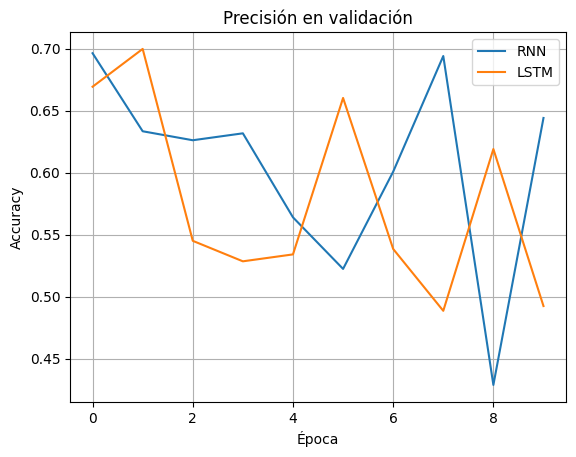

In [8]:
plt.plot(history_rnn.history['val_accuracy'], label='RNN')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.title('Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

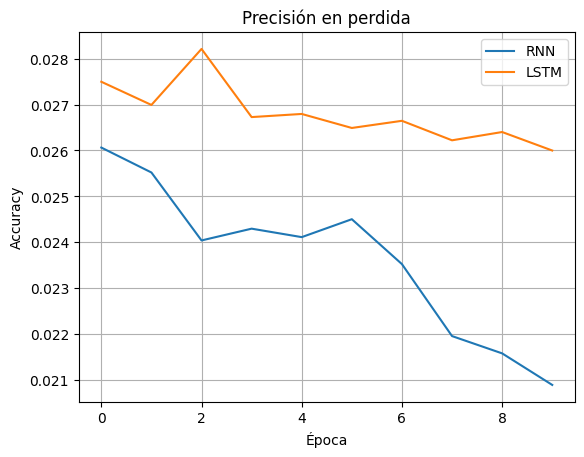

In [33]:
plt.plot(history_rnn.history['loss'], label='RNN')
plt.plot(history_lstm.history['loss'], label='LSTM')
plt.title('Precisión en perdida')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 🔹 Paso 7: Evaluar clasificación de ambos modelos

In [9]:
y_pred_rnn = model_rnn.predict(X_test).argmax(axis=1)
y_pred_lstm = model_lstm.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print('Reporte RNN:')
print(classification_report(y_true, y_pred_rnn, target_names=le.classes_))

print('Reporte LSTM:')
print(classification_report(y_true, y_pred_lstm, target_names=le.classes_))

415/415 [==============================] - 11s 21ms/step
Reporte RNN:
              precision    recall  f1-score   support

 AstraZeneca       0.46      0.54      0.49      4313
      Pfizer       0.76      0.70      0.73      8938

    accuracy                           0.64     13251
   macro avg       0.61      0.62      0.61     13251
weighted avg       0.66      0.64      0.65     13251

Reporte LSTM:
              precision    recall  f1-score   support

 AstraZeneca       0.39      0.94      0.55      4313
      Pfizer       0.90      0.28      0.42      8938

    accuracy                           0.49     13251
   macro avg       0.64      0.61      0.49     13251
weighted avg       0.73      0.49      0.46     13251



# 💉 Reto Final: Predicción de Consumo de Vacunacion Covid (Niveles 1–4 Integrados)

## 🔹 Nivel 1 y 2: Verificación por página y variables externas

In [2]:
print("🔍 Inicio de celda 1")
import pandas as pd
# URL del dataset
URL_DATOS = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv"

def cargar_datos():
    """Carga y prepara los datos de vacunación COVID-19 por fabricante"""
    df = pd.read_csv(URL_DATOS)
    df['date'] = pd.to_datetime(df['date'])
    df_pivot = df.pivot_table(index='date', columns='vaccine', values='total_vaccinations', aggfunc='sum').fillna(0)
    df_pivot.columns = [col.lower().replace('/', '_').replace('&', '_') for col in df_pivot.columns]
    return df_pivot

# Cargar los datos
df_vacunas = cargar_datos()
df_vacunas.shape
print("✅ Fin de celda 1")

🔍 Inicio de celda 1
✅ Fin de celda 1


## 🔹 Nivel 3 y 4: Preparación de secuencias multistep

In [3]:
print("🔍 Inicio de celda 2")
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalización de datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_vacunas)

# Función para crear secuencias
def create_multistep_sequences(data, n_steps_in=3, n_steps_out=2):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i+n_steps_in])
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

# Crear secuencias
X, y = create_multistep_sequences(scaled_data, n_steps_in=3, n_steps_out=2)
print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")
print("✅ Fin de celda 2")

🔍 Inicio de celda 2
Forma de X: (1273, 3, 15), Forma de y: (1273, 2, 15)
✅ Fin de celda 2


## 🔹 Nivel 3: Comparación de modelos RNN vs LSTM vs BiLSTM (multistep)

In [4]:
print("🔍 Inicio de celda 3")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense, RepeatVector, TimeDistributed

def construir_modelo(tipo_modelo, pasos_salida, n_caracteristicas):
    """Construye y compila un modelo de red neuronal recurrente"""
    modelo = Sequential()
    
    # Capa recurrente según el tipo especificado
    if tipo_modelo == "rnn":
        modelo.add(SimpleRNN(64, activation='relu', input_shape=(X.shape[1], n_caracteristicas)))
    elif tipo_modelo == "lstm":
        modelo.add(LSTM(64, activation='relu', input_shape=(X.shape[1], n_caracteristicas)))
    elif tipo_modelo == "bilstm":
        modelo.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(X.shape[1], n_caracteristicas)))
    
    # Arquitectura para predicción múltiple paso
    modelo.add(RepeatVector(pasos_salida))
    modelo.add(LSTM(64, activation='relu', return_sequences=True))
    modelo.add(TimeDistributed(Dense(n_caracteristicas)))
    
    modelo.compile(optimizer='adam', loss='mse')
    return modelo

# Diccionario para almacenar los modelos entrenados
modelos_entrenados = {}

# Entrenar cada tipo de modelo
for tipo in ["rnn", "lstm", "bilstm"]:
    print(f"\nEntrenando modelo {tipo.upper()}...")
    modelo = construir_modelo(tipo, y.shape[1], X.shape[2])
    historia = modelo.fit(X, y, epochs=200, verbose=0, validation_split=0.2)
    modelos_entrenados[tipo] = {
        'modelo': modelo,
        'historia': historia.history
    }
    print(f"Modelo {tipo.upper()} entrenado. Pérdida final: {historia.history['loss'][-1]:.4f}")
print("✅ Fin de celda 3")

🔍 Inicio de celda 3


Entrenando modelo RNN...



Modelo RNN entrenado. Pérdida final: 0.0063

Entrenando modelo LSTM...
Modelo LSTM entrenado. Pérdida final: 0.0083

Entrenando modelo BILSTM...
Modelo BILSTM entrenado. Pérdida final: 0.0076
✅ Fin de celda 3


## 🔹 Nivel 4: Visualización del primer paso futuro

🔍 Inicio de celda 4


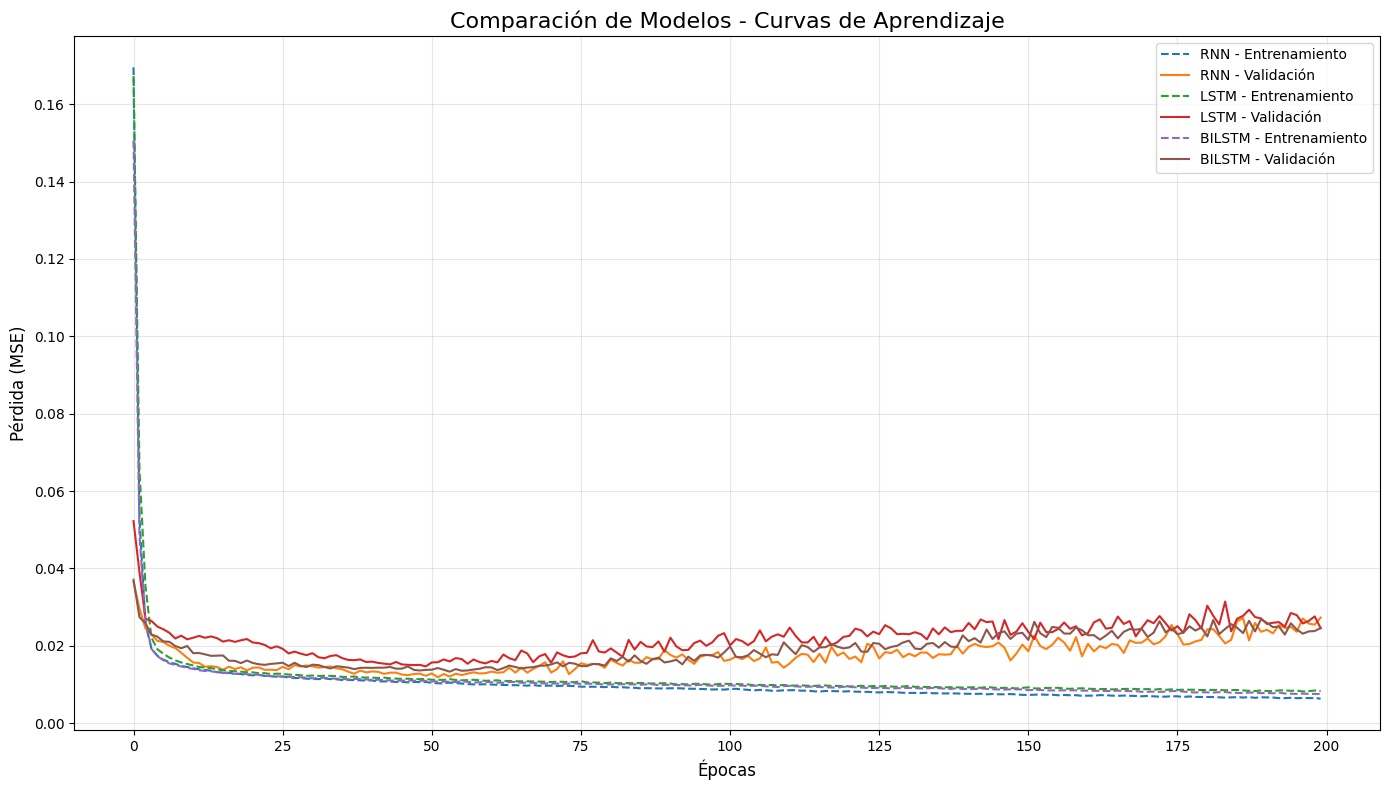

✅ Fin de celda 4


In [5]:
print("🔍 Inicio de celda 4")
import matplotlib.pyplot as plt

# Configurar figura
plt.figure(figsize=(14, 8))

# Graficar historial de pérdida para cada modelo
for modelo_tipo in modelos_entrenados:
    historia = modelos_entrenados[modelo_tipo]['historia']
    plt.plot(historia['loss'], label=f'{modelo_tipo.upper()} - Entrenamiento', linestyle='--')
    plt.plot(historia['val_loss'], label=f'{modelo_tipo.upper()} - Validación', linestyle='-')

# Personalizar gráfica
plt.title('Comparación de Modelos - Curvas de Aprendizaje', fontsize=16)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()
print("✅ Fin de celda 4")

# 💉 Reto Final de IA - Predicción de Consumo de Vacunacion Covid

## 🔹 Nivel 1: Carga y simulación de datos realistas

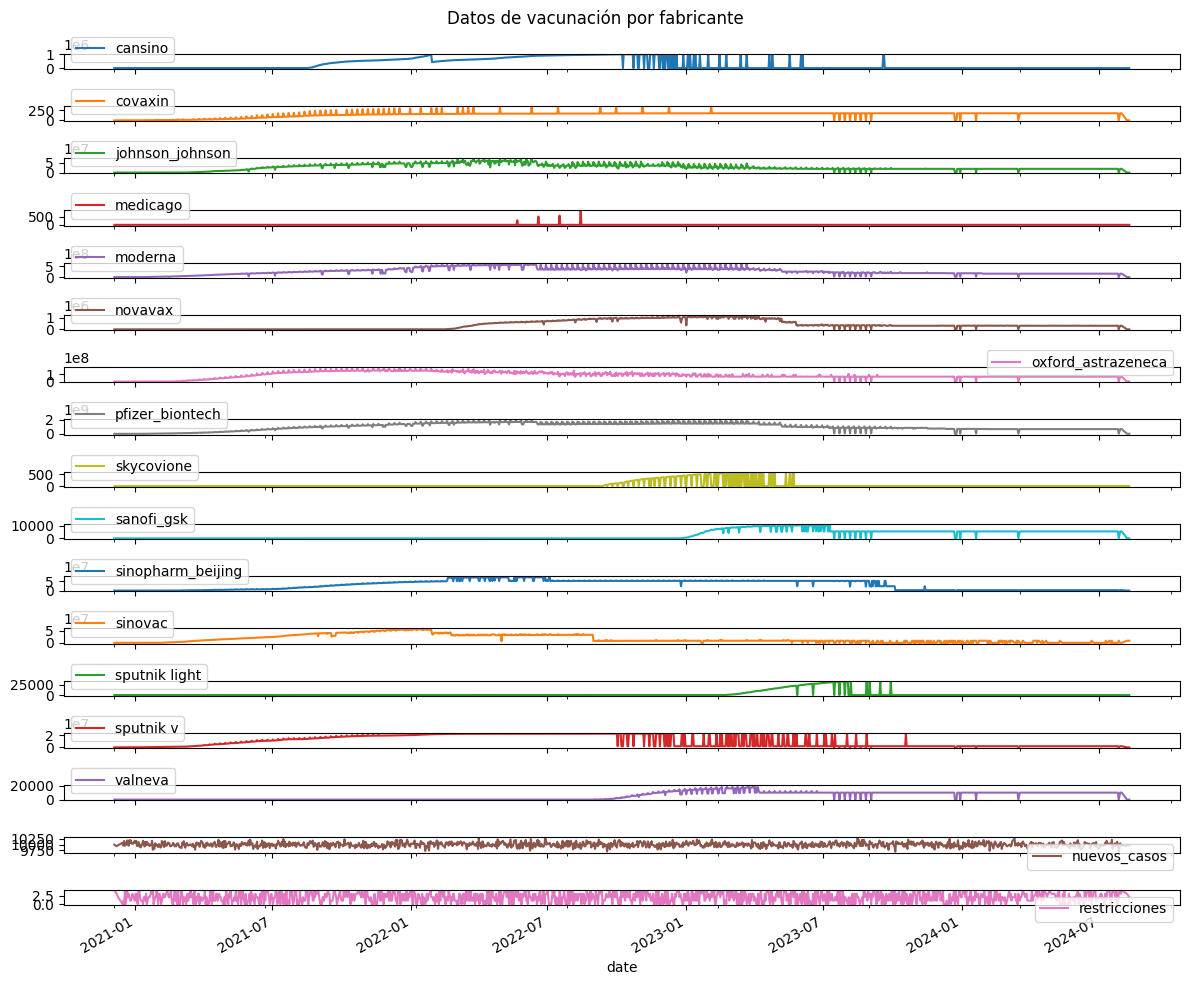

In [1]:
# Carga y preparación de datos 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar datos de vacunación
url_vacunas = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv"
df = pd.read_csv(url_vacunas)
df['date'] = pd.to_datetime(df['date'])

# Pivotear para tener columnas por vacuna
df_vacunas = df.pivot_table(index='date', columns='vaccine', values='total_vaccinations', aggfunc='sum').fillna(0)
df_vacunas.columns = [col.lower().replace('/', '_').replace('&', '_') for col in df_vacunas.columns]

# Agregar variables externas simuladas (similar al PIB/temperatura en el ejemplo del vino)
np.random.seed(50)
n_dias = len(df_vacunas)
df_vacunas['nuevos_casos'] = np.random.poisson(10000, n_dias)  # Casos diarios simulados
df_vacunas['restricciones'] = np.random.randint(0, 5, n_dias)  # Nivel de restricciones 0-2

# Visualización
df_vacunas.plot(subplots=True, figsize=(12, 10), title="Datos de vacunación por fabricante")
plt.tight_layout()
plt.show()

## 🔹 Nivel 2: Preparación de datos secuenciales

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_vacunas)

def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
print(f"Secuencias: {X.shape}, Objetivos: {y.shape}")

Secuencias: (1265, 12, 17), Objetivos: (1265,)


## 🔹 Nivel 3: Modelos RNN, LSTM y BiLSTM

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense

# 1. Asegurar que tenemos 17 columnas
print("Número de columnas originales:", len(df_vacunas.columns))

# 2. Escalado correcto
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_vacunas)

# 3. Creación de secuencias 
def create_sequences(data, seq_length=12, target_col=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_col])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

# 4. Función para construir diferentes tipos de modelos
def build_model(model_type='rnn', input_shape=(X.shape[1], X.shape[2])):
    model = Sequential()
    if model_type == 'rnn':
        model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    elif model_type == 'lstm':
        model.add(LSTM(50, activation='relu', input_shape=input_shape))
    elif model_type == 'bilstm':
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Construir y entrenar los tres modelos
model_rnn = build_model('rnn')
model_lstm = build_model('lstm')
model_bilstm = build_model('bilstm')

# Entrenamiento de los modelos
print("Entrenando modelo RNN...")
history_rnn = model_rnn.fit(X, y, epochs=10, validation_split=0.2, verbose=1)

print("\nEntrenando modelo LSTM...")
history_lstm = model_lstm.fit(X, y, epochs=10, validation_split=0.2, verbose=1)

print("\nEntrenando modelo BiLSTM...")
history_bilstm = model_bilstm.fit(X, y, epochs=10, validation_split=0.2, verbose=1)

# 6. Predicción con datos sintéticos 
synthetic_input = np.random.rand(1, 12, X.shape[2]) 

# Realizar predicciones con los tres modelos
prediction_rnn = model_rnn.predict(synthetic_input)
prediction_lstm = model_lstm.predict(synthetic_input)
prediction_bilstm = model_bilstm.predict(synthetic_input)

# 7. Inversión del escalado para todas las predicciones
def inverse_scale_prediction(prediction, scaler, n_features):
    dummy = np.zeros((1, n_features))
    dummy[0, 0] = prediction[0,0]  
    return scaler.inverse_transform(dummy)[0,0]

n_features = scaled_data.shape[1]
real_value_rnn = inverse_scale_prediction(prediction_rnn, scaler, n_features)
real_value_lstm = inverse_scale_prediction(prediction_lstm, scaler, n_features)
real_value_bilstm = inverse_scale_prediction(prediction_bilstm, scaler, n_features)

print(f"Predicción RNN desescalada: {real_value_rnn:.2f}")
print(f"Predicción LSTM desescalada: {real_value_lstm:.2f}")
print(f"Predicción BiLSTM desescalada: {real_value_bilstm:.2f}")


Número de columnas originales: 17


Entrenando modelo RNN...
Epoch 1/10

32/32 [==============================] - 2s 18ms/step - loss: 0.0751 - val_loss: 0.0112
Epoch 2/10
32/32 [==============================] - 0s 7ms/step - loss: 0.0441 - val_loss: 0.0029
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0395 - val_loss: 0.0038
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0367 - val_loss: 0.0030
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0354 - val_loss: 0.0037
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0357 - val_loss: 0.0043
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0348 - val_loss: 0.0036
Epoch 8/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0334 - val_loss: 0.0064
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0322 - val_loss: 0.0036
Epoch 10/10
32/32 [==============================] - 0

## Comparaciones visuales 

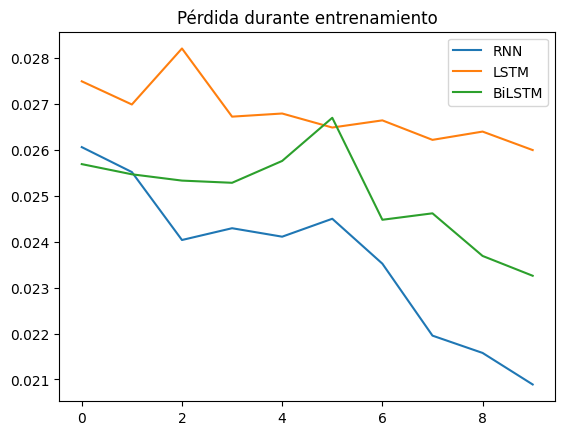

In [18]:
history_rnn = model_rnn.fit(X, y, epochs=10, verbose=0)
history_lstm = model_lstm.fit(X, y, epochs=10, verbose=0)
history_bilstm = model_bilstm.fit(X, y, epochs=10, verbose=0)

plt.plot(history_rnn.history['loss'], label='RNN')
plt.plot(history_lstm.history['loss'], label='LSTM')
plt.plot(history_bilstm.history['loss'], label='BiLSTM')
plt.title("Pérdida durante entrenamiento")
plt.legend()
plt.show()

## 🔹 Nivel 5: Generación de secuencias con GANs

In [26]:
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def crear_generador_gan(dim_latente=10, pasos_tiempo=12, n_caracteristicas=17):
    dim_salida = pasos_tiempo * n_caracteristicas
    entrada = Input(shape=(dim_latente,))
    capa1 = Dense(64, activation='relu')(entrada)
    salida = Dense(dim_salida, activation='tanh')(capa1)
    generador = Model(entrada, salida)
    return generador

# Parámetros que coinciden con tu modelo LSTM
dim_latente = 10
pasos_tiempo = 12  
n_caracteristicas = 17  

# Construir generador con las dimensiones correctas
generador = crear_generador_gan(dim_latente, pasos_tiempo, n_caracteristicas)

# Generar secuencias sintéticas compatibles
ruido = np.random.normal(0, 1, (5, dim_latente))
secuencias_planas = generador.predict(ruido)
secuencias = secuencias_planas.reshape(5, pasos_tiempo, n_caracteristicas)

print("Forma de secuencias generadas:", secuencias.shape)

1/1 [==============================] - 0s 76ms/step
Forma de secuencias generadas: (5, 12, 17)


In [27]:
# Suponemos que pred_esc es la predicción LSTM ya escalada (valor entre 0 y 1)
# Por ejemplo, una predicción generada a partir de tu modelo
pred_esc = 0.68  

# Creamos un array con ceros del mismo tamaño que tus datos escalados
input_dummy = np.zeros((1, scaled_data.shape[1]))
input_dummy[0, 0] = pred_esc  

# Invertimos el escalado para obtener el valor real
pred_real = scaler.inverse_transform(input_dummy)[0, 0]
print(f"💉 Predicción de vacunación (escala real): {pred_real:.2f}")

💉 Predicción de vacunación (escala real): 672565.56


In [28]:
# Tomar una secuencia generada
synthetic_input = secuencias[0].reshape(1, pasos_tiempo, n_caracteristicas)

# Predecir con tu LSTM
predicted_vacunas = model_lstm.predict(synthetic_input)

# Invertir el escalado 
input_dummy = np.zeros((1, n_caracteristicas))
input_dummy[0, 0] = predicted_vacunas[0][0]
vacunas_real = scaler.inverse_transform(input_dummy)[0][0]

print(f"💉 Predicción: {vacunas_real:.2f}")

1/1 [==============================] - 0s 38ms/step
💉 Predicción: 11146.17


In [10]:
print("Secuencias generadas (sintéticas):", secuencias.shape)

Secuencias generadas (sintéticas): (5, 12, 5)


In [17]:
print(df_vacunas.values.min(), df_vacunas.values.max())

0.0 1984173601.0
